### Mount Google Drive

In [0]:
from google.colab import drive 
drive.mount("/content/drive") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!sudo pip install h5py

### Importing Libraries

In [0]:
import glob
import cv2
import re
import numpy as np
import random
import matplotlib.pyplot as plt
#import tqdm as tqdm
from tqdm.notebook import tqdm

from tensorflow import keras

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
#from keras.utils.np_utils import to_categorical 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from sklearn.model_selection import train_test_split


### Set the directory

In [0]:
import os
os.chdir("/content/drive/My Drive/Other/data")

### Train and Test Data Path

In [0]:
import pathlib
train_dir = pathlib.Path("train")
test_dir = pathlib.Path("test")

### Target image size and batch size

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

### Define Train and Test Data generator

In [0]:
train_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input, width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1, horizontal_flip=True,
                      validation_split=0.30)

test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input)

### Read the Train data as two parts - Train and Validation

In [0]:

train_generator = train_data_generator.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=1,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = train_data_generator.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=1,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 3780 images belonging to 15 classes.
Found 1620 images belonging to 15 classes.


### Read the Test Data

In [0]:
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=50,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)


Found 1800 images belonging to 15 classes.


### Check the categoriess

In [0]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')]) 

In [0]:
CLASS_NAMES

array(['bedroom', 'beach', 'airport_terminal', 'skyscraper',
       'forest_path', 'Cathedral_outdoor', 'bridge', 'house',
       'market_outdoor', 'playground', 'restaurant', 'coral_reef',
       'dining_room', 'highway', 'mountain'], dtype='<U17')

### No of data points for each part

In [0]:
print("No of Training Images:",train_generator.n)
print("No of Validation Images:",validation_generator.n)
print("No of Test Images:",test_generator.n)

No of Training Images: 3780
No of Validation Images: 1620
No of Test Images: 1800


### Check shape of one train batch

In [0]:
train_generator.__getitem__(0)[0].shape

(32, 224, 224, 3)

In [0]:
## To check no of images per category in train data
# for i in range(len(CLASS_NAMES)):
#   print(CLASS_NAMES[i])
#   print(len(list(train_dir.glob(str(CLASS_NAMES[i]) +'/*'))))

### Visualization 

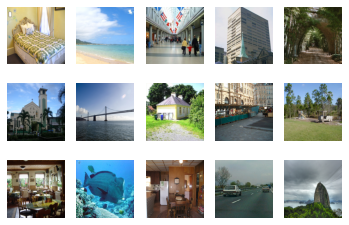

In [0]:
from PIL import Image
import random

## Randomly select an image from first 200 images of each category and show 
rows = 3
cols = 5
k = 0
fig, axs = plt.subplots(rows, cols)
for i in range(rows):
  for j in range(cols):
    r = random.randrange(0, 200, 1)
    path = list(train_dir.glob(str(CLASS_NAMES[k]) +'/*'))[r]
    img = Image.open(path)
    img = img.resize((500,500), Image.ANTIALIAS)

    axs[i,j].imshow(img)
    axs[i,j].axis('off')
    #axs[i,j].set_title(str(CLASS_NAMES[k]))
    k = k + 1  

### Define Model

### Pre-trained Model

In [0]:
base_model = ResNet101(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights="imagenet") 
# flat1 = Flatten()
# dense_1 = Dense128, activation = "relu")
# model = Model(inputs=base_model.inputs, outputs=output) 
base_model.trainable = False

In [0]:
print("No of layers now in the base model:",len(base_model.layers))

No of layers now in the base model: 345


### Summary of Base Model

In [0]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

### Define the callback functions

In [0]:
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.001, patience= 20, verbose= 1, mode='auto', baseline=None, restore_best_weights=False)
mcp = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose= 1, save_best_only= True, save_weights_only=False, mode='auto', period=1)
rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience= 3, verbose=1, mode='auto', min_lr=0)


#### Define our model using base model

In [0]:
model = Sequential([base_model])
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation = "relu"))
#model.add(BatchNormalization())
model.add(Dropout(0.25))
# model.add(Dense(128, activation = "relu"))
# model.add(Dropout(0.5))
model.add(Dense(15, activation = "softmax"))

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optimizer = RMSprop(learning_rate=0.001)


model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Summary of final model

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3855      
Total params: 68,753,807
Trainable params: 25,894,927
Non-trainable params: 42,858,880
_________________________________

### Fit model

In [0]:
## Define epoch, steps
EPOCHS = 20
steps_per_epoch = 50 #train_generator.__len__() 
validation_steps = 30 #validation_generator.__len__() 


history = model.fit(train_generator,
	 steps_per_epoch= steps_per_epoch, validation_data=validation_generator, validation_steps = validation_steps,
	epochs=EPOCHS, verbose =1, callbacks=[mcp,rlr])

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 2.1481 - accuracy: 0.2975
Epoch 00001: val_accuracy improved from -inf to 0.17188, saving model to best_model.h5
50/50 [==============================] - 63s 1s/step - loss: 2.1481 - accuracy: 0.2975 - val_loss: 3.1155 - val_accuracy: 0.1719 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.7758 - accuracy: 0.4125
Epoch 00002: val_accuracy improved from 0.17188 to 0.22152, saving model to best_model.h5
50/50 [==============================] - 62s 1s/step - loss: 1.7758 - accuracy: 0.4125 - val_loss: 2.5195 - val_accuracy: 0.2215 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 1.4687 - accuracy: 0.5274
Epoch 00003: val_accuracy improved from 0.22152 to 0.29896, saving model to best_model.h5
50/50 [==============================] - 63s 1s/step - loss: 1.4687 - accuracy: 0.5274 - val_loss: 2.0891 - val_accuracy: 0.2990 - lr: 1.0000e-04
Epoch 4/20
50

### Validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate(validation_generator, steps = validation_steps)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

30/30 [==============================] - 13s 448ms/step - loss: 1.5606 - accuracy: 0.5208
Validation loss: 1.5605762004852295
Validation accuracy: 0.5208333134651184


### Test loss and accuracy

In [0]:
test_loss, test_acc = model.evaluate(test_generator, steps = 25)
print("Test loss:", test_loss) 
print("Test accuracy:", test_acc)

25/25 [==============================] - 390s 16s/step - loss: 1.5241 - accuracy: 0.5475
Test loss: 1.5241038799285889
Test accuracy: 0.5475000143051147


### Plot of accuracy and loss with epoch

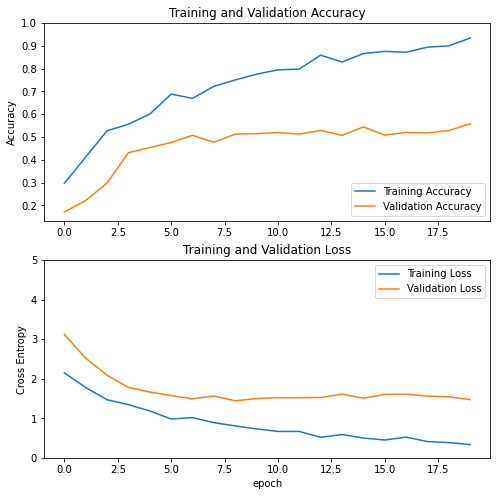

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune the model
#### Unfreezing the layers of pre-trained model

In [0]:
base_model.trainable =True

In [0]:
# No of layers
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
## Here we learn all the weights, so the 0 below
fine_tune_at = 0

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  345


### Compile the model

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Model Summary

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3855      
Total params: 68,753,807
Trainable params: 68,447,759
Non-trainable params: 306,048
____________________________________

### Fit the model again after fine tuning

In [0]:
fine_tune_epochs = 30
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_generator,
	 steps_per_epoch= steps_per_epoch, validation_data=validation_generator, epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],validation_steps = validation_steps,
	                      verbose =1, callbacks=[mcp,rlr])

Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 1.0313 - accuracy: 0.7394
Epoch 00020: val_accuracy did not improve from 0.55802
50/50 [==============================] - 68s 1s/step - loss: 1.0313 - accuracy: 0.7394 - val_loss: 23.5161 - val_accuracy: 0.0738 - lr: 2.0000e-05
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.3619 - accuracy: 0.9141
Epoch 00021: val_accuracy did not improve from 0.55802
50/50 [==============================] - 65s 1s/step - loss: 0.3619 - accuracy: 0.9141 - val_loss: 15.6826 - val_accuracy: 0.0760 - lr: 2.0000e-05
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.9312
Epoch 00022: val_accuracy did not improve from 0.55802
50/50 [==============================] - 66s 1s/step - loss: 0.2792 - accuracy: 0.9312 - val_loss: 7.7575 - val_accuracy: 0.0707 - lr: 2.0000e-05
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9478
Epoch 00023: va

### Validation loss and accuracy

In [0]:
print("No of validation batches:",validation_generator.__len__())

No of validation batches: 51


In [0]:
val_loss, val_acc = model.evaluate(validation_generator, steps = 51)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

51/51 [==============================] - 23s 443ms/step - loss: 0.3852 - accuracy: 0.9160
Validation loss: 0.3852367103099823
Validation accuracy: 0.9160493612289429


### Test loss and accuracy

In [0]:
print("No of test batches:",test_generator.__len__())

No of test batches: 57


In [0]:
test_loss, test_acc = model.evaluate(test_generator, steps = 57)
print("Test loss:", test_loss) 
print("Test accuracy:", test_acc)

57/57 [==============================] - 489s 9s/step - loss: 0.3329 - accuracy: 0.9222
Test loss: 0.3329121768474579
Test accuracy: 0.9222221970558167


### Plot

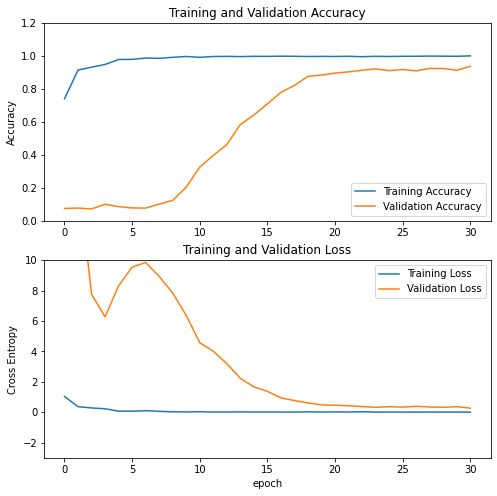

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.2])
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-3,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()